# **Preparación de los datos**

In [2]:
!pip install tensorflow-io --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 19.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 41.8 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0


In [3]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [10]:
def load_dataset(path, size, test_size=0.2, val_size=0.2, random_state=42, os_factor=10):
    images = []
    labels = []
    classes = os.listdir(path)
    labels_dict = {}  # Diccionario para mapear las lbls de las imagenes
    
    for i, class_lbl in enumerate(classes):
        folder = os.path.join(path, class_lbl)
        files = os.listdir(folder)
        for file in files:
            file_path = os.path.join(folder, file)
            img = Image.open(file_path)
            img = img.resize(size)          # Redimensionar la imagen
            img = np.array(img)             # Convertir la imagen a un arreglo NumPy
            images.append(img)
            labels.append(i)
        labels_dict[i] = class_lbl          # Asignar el nombre de la carpeta como lbl de la imagen
    
    images = np.array(images) / 255.0       # Normalizar los valores de píxel entre 0 y 1
    labels = to_categorical(labels)         # Convertir las labels a representación one-hot
    print(images.shape)
    
    # Aumentar el tamaño del dataset
    images_os, labels_os = oversampling_dataset(images, labels, os_factor = os_factor)
    print(images_os.shape)

    # Estanadarizar tamaño de las imágenes
    images_os = standarize_sizes(images_os, size)
    
    # Dividir de datos en entrenamiento, prueba y validacion de manera estratificada
    train_images, test_images, \
    train_labels, test_labels = train_test_split(
        images_os,
        labels_os,
        test_size=(test_size+val_size),
        random_state=random_state,
        stratify=labels_os
    )
    
    val_images, test_images, \
    val_labels, test_labels = train_test_split(
        test_images,
        test_labels,
        test_size=test_size/(test_size+val_size),
        random_state=random_state,
        stratify=test_labels
    )

    print('Dataset generado exitosamente!')
    return train_images, test_images, val_images, \
        train_labels, test_labels, val_labels, labels_dict

def oversampling_dataset(images, labels, os_factor=10):
    print(f'Aumentando dataset x{os_factor}...')
    datagen = ImageDataGenerator(
        rotation_range=10,          # Rango de rotación en grados
        width_shift_range=0.1,      # Rango de desplazamiento horizontal
        height_shift_range=0.1,     # Rango de desplazamiento vertical
        zoom_range=0.1,             # Rango de zoom
        horizontal_flip=True,       # Volteo horizontal
        fill_mode='nearest'  
    )
    
    images_os = []
    labels_os = []
    
    for i in range(len(images)):
        img = images[i]
        lbl = labels[i]
        
        img_os = np.expand_dims(img, axis=0)
        lbl_os = np.expand_dims(lbl, axis=0)
        
        # Generar imágenes aumentadas adicionales
        batch = datagen.flow(img_os, lbl_os, batch_size=1)
        for _ in range(os_factor):
            img_generated, lbl_generated = next(batch)
            img_generated = np.squeeze(img_generated, axis=0)
            lbl_generated = np.squeeze(lbl_generated, axis=0)
            
            images_os.append(img_generated)
            labels_os.append(lbl_generated)
    
    images_os = np.array(images_os)
    labels_os = np.array(labels_os)
    
    return images_os, labels_os

def standarize_sizes(images, size):
    print('Convirtiendo a escala de grises...')
    images_standarized = []
    for img in images:
        # Escalar los valores de píxeles al rango 0-255 y convertir a tipo entero
        img = (img - np.min(img)) * 255 / (np.max(img) - np.min(img))
        img = img.astype(np.uint8)
        
        # Redimensionar la img y convertir a escala de grises
        img_reducida = Image.fromarray(img)
        img_reducida = img_reducida.resize(size).convert('L')
        img_reducida = np.array(img_reducida)
        
        images_standarized.append(img_reducida)
    
    return np.array(images_standarized)

path_dataset = '/kaggle/input/terrenos'
size_img = (300, 450)  # En píxeles

train_images, test_images, val_images, \
train_labels, test_labels, val_labels, \
labels_dict = load_dataset(path_dataset,
                                 size_img,
                                 os_factor=15)

print(f"Train images: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Test images:  {test_images.shape}, Labels: {test_labels.shape}")
print(f"Val images:   {val_images.shape}, Labels: {val_labels.shape}")

# Obtener las labels numéricas para entrenamiento y testeo
labels_train = np.argmax(train_labels, axis=1)
labels_test = np.argmax(test_labels, axis=1)
labels_val = np.argmax(val_labels, axis=1)

# Contar la frecuencia de las labels en el conjunto de entrenamiento
count_train = pd.Series(labels_train).value_counts().sort_index()

# Contar la frecuencia de las labels en el conjunto de testeo
count_test = pd.Series(labels_test).value_counts().sort_index()

# Contar la frecuencia de las labels en el conjunto de validacion
count_val = pd.Series(labels_val).value_counts().sort_index()

# Crear un DataFrame para mostrar los resultados
df_count = pd.DataFrame({'Etiqueta': list(labels_dict.values()),
                          'Entrenamiento': count_train,
                          'Testeo': count_test,
                          'Validacion': count_val})
df_count['Total'] = df_count[['Entrenamiento', 'Testeo', 'Validacion']].sum(axis=1)

# Guardar el dataset en un file
with open('dataset_terrains_v2.pickle', 'wb') as file:
    data = {
        'train_images': train_images,
        'test_images': test_images,
        'val_images': val_images,
        'train_labels': train_labels,
        'test_labels': test_labels,
        'val_labels': val_labels
    }
    pickle.dump(data, file)
print('Se ha guardado exitosamente el dataset')    

df_count

(258, 450, 300, 3)
Aumentando dataset x15...
(3870, 450, 300, 3)
Convirtiendo a escala de grises...
Dataset generado exitosamente!
Train images: (2322, 450, 300), Labels: (2322, 4)
Test images:  (774, 450, 300), Labels: (774, 4)
Val images:   (774, 450, 300), Labels: (774, 4)
Se ha guardado exitosamente el dataset


,Etiqueta,Entrenamiento,Testeo,Validacion,Total
0,CARRETERA,585,195,195,975
1,TIERRA SECA,594,198,198,990
2,TIERRA LODOSA,567,189,189,945
3,PEDREGOSO,576,192,192,960


In [11]:
# Leer el dataset desde el archivo
with open('dataset_terrains_v2.pickle', 'rb') as file:
    data = pickle.load(file)

train_images = data['train_images']
test_images = data['test_images']
val_images = data['val_images']
train_labels = data['train_labels']
test_labels = data['test_labels']
val_labels = data['val_labels']

## **Visualizacion de muestras**

In [19]:
labels_dict

{0: 'CARRETERA', 1: 'TIERRA SECA', 2: 'TIERRA LODOSA', 3: 'PEDREGOSO'}

[0. 0. 0. 1.]


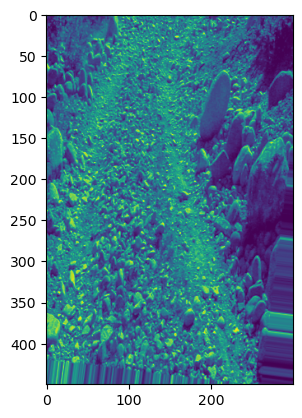

In [20]:
i = 85
print(train_labels[i])
plt.imshow(train_images[i])

[1. 0. 0. 0.]


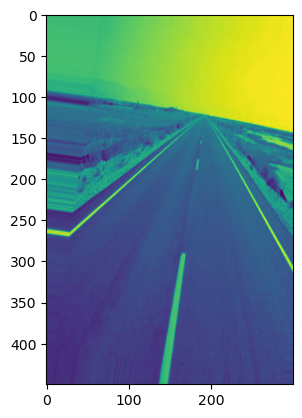

In [13]:
i = 250
print(train_labels[i])
plt.imshow(train_images[i])

[0. 0. 0. 1.]


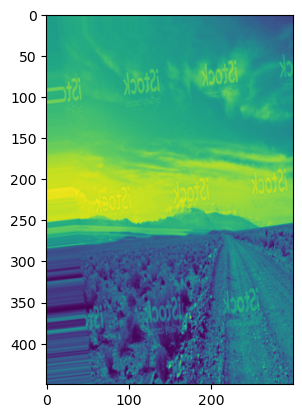

In [14]:
i = 81
print(train_labels[i])
plt.imshow(train_images[i])

[0. 1. 0. 0.]


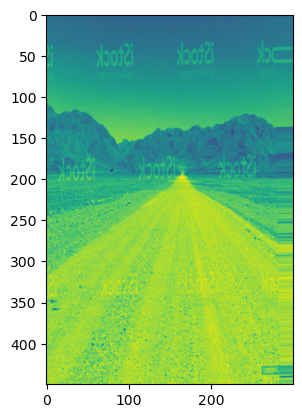

In [15]:
i = 1050
print(train_labels[i])
plt.imshow(train_images[i])